# DKL with custom CNN

Here we use two kinds of DKL initializers to process the ICCD images generated by PLD experiments. 
The first is the ICCDMixedNet that uses a (2+1)D CNN 
The second uses a RCNN.

# Imports

In [ ]:
import matplotlib.pylab as plt
import numpy as np

import random
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, ConcatDataset

# Import GP and BoTorch functions
import gpytorch as gpt
import pandas as pd
from botorch.models import SingleTaskGP, ModelListGP

#from botorch.models import gpytorch
# from botorch.fit import fit_gpytorch_model
from botorch.models.gpytorch import GPyTorchModel
from botorch.utils import standardize
from gpytorch.distributions import MultivariateNormal
from gpytorch.kernels import ScaleKernel, RBFKernel, MaternKernel, PeriodicKernel
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.means import ConstantMean, LinearMean
from gpytorch.mlls import ExactMarginalLogLikelihood
from gpytorch.likelihoods.likelihood import Likelihood
from gpytorch.constraints import GreaterThan
from gpytorch.models import ExactGP
from mpl_toolkits.axes_grid1 import make_axes_locatable
# from smt.sampling_methods import LHS
from torch.optim import SGD
from torch.optim import Adam
from scipy.stats import norm



In [3]:

from GP_functions import *
from custom_models import *
from ICCD_Dataset import *
from Plot_DKL_predictions import *


# Functions

In [4]:

def norm_0to1_tensor(X):

    norm_tensor = torch.empty_like(X)

    for i in range(X.shape[-1]):
        torch_i = X[:, i]
        norm_i = (torch_i - torch.min(torch_i))/(torch.max(torch_i) - torch.min(torch_i))
        norm_tensor[:, i] = norm_i
           
    return norm_tensor

def extract_data(dataloader, norm = True):
    images = []
    params =[]
    scores = []
    indices = []

    for i, (images_i, params_i, score_i) in enumerate(dataloader):

        images.append(images_i)
        params.append(params_i)
        scores.append(score_i)

        indices.append(i)

    

    images = torch.cat(images, axis=0)
    params = torch.cat(params, axis=0)
    scores = torch.cat(scores, axis=0)
    indices = np.array(indices)
    

    if norm:
        params = norm_0to1_tensor(params)
        scores = norm_0to1_tensor(scores)

    return images, params, scores, indices



def append_to_train(X, y, params, X_train, y_train, train_params, train_indices, ind):
    X_train = torch.cat((X_train, X[ind:ind+1]), axis=0)
    y_train = torch.cat((y_train, y[ind:ind+1]), axis=0)
    train_params = torch.cat((train_params, params[ind:ind+1]), axis=0)
    train_indices = np.hstack((train_indices, ind))

    return X_train, y_train, train_params, train_indices

def plot_training_loss(training_loss, testing_loss):
    plt.figure(figsize = (4,4))
    plt.semilogy(training_loss, label = 'Train Loss')
    plt.semilogy(testing_loss, label = 'Test Loss')
    plt.ylabel("Epoch loss")
    plt.xlabel("Epochs")
    plt.legend()
    plt.show()

# Get dataset

In [5]:
datafile = 'data/PLD data.json'

# Get the raw dataset, wo transforms
dataset1 = ICCDDataset(datafile)


# Define the transform1
transform = transforms.RandomAffine(180,
                                    translate=(0.1,0.1),
                                    shear=10,
                                    scale=(0.8,1.2))
# Define the dataset with the transform
dataset2 = ICCDDataset(datafile, transform = transform)


# Define the transform with Gaussian noise
transform_with_noise = transforms.Compose([
    transforms.RandomAffine(180, translate=(0.1, 0.1), shear=10, scale=(0.8, 1.2)),
    AddGaussianNoise(mean=0.0, std=0.1)
])

# Define the noise for parameters
param_noise = AddGaussianNoise(mean=0.0, std=0.1)

# Define the dataset with the transform and noise
dataset3 = ICCDDataset(datafile, transform=transform_with_noise, params_noise=param_noise)


# Combine the datsets
dataset = ConcatDataset([dataset1, dataset2, dataset3])



In [6]:
dataloader = DataLoader(dataset, batch_size=1, shuffle=False)

X, orig_params, score, _ = extract_data(dataloader, norm = False)

X, params, y, indices = extract_data(dataloader)




In [10]:
from sklearn.model_selection import train_test_split
train_X, test_X, train_params, test_params, train_y, test_y, train_indices, test_indices =train_test_split(X, params, y, indices, test_size=0.2, random_state=24)
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

train_dataset = TrainDataset(train_X, train_params, train_y, transform = None)
test_dataset = TrainDataset(test_X, test_params, test_y, transform = None)

torch.Size([304, 1, 50, 40, 40]) torch.Size([304, 1]) torch.Size([77, 1, 50, 40, 40]) torch.Size([77, 1])


# 1. DKL with ICCDNet

## Single step training

In [24]:
custom_nn = ICCDNet(output_dim = 5)

latent_dim: 2


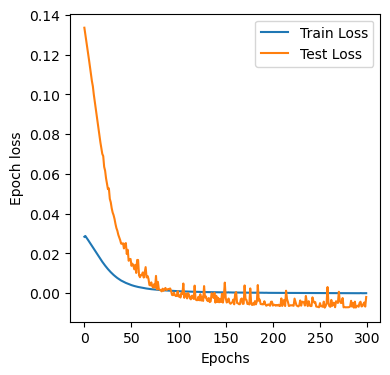

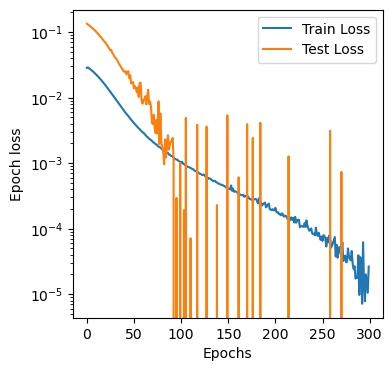

latent_dim: 3


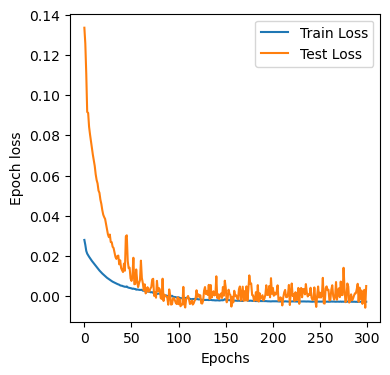

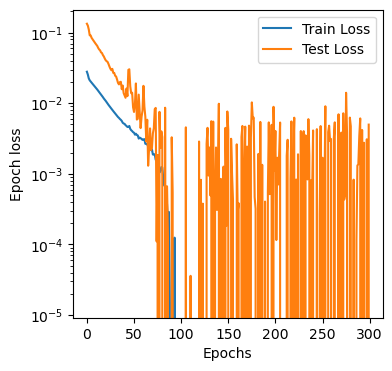

latent_dim: 6


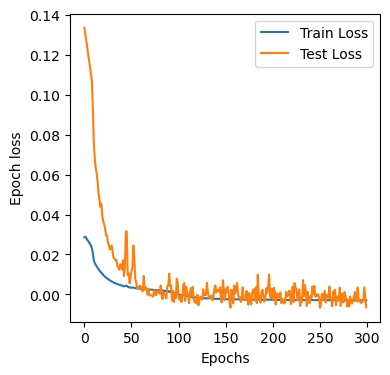

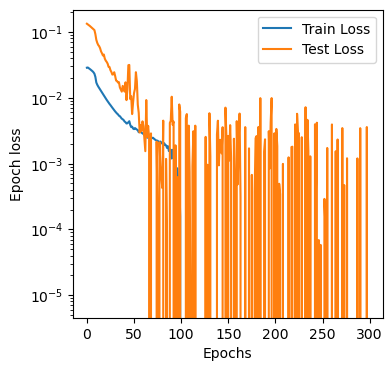

latent_dim: 8


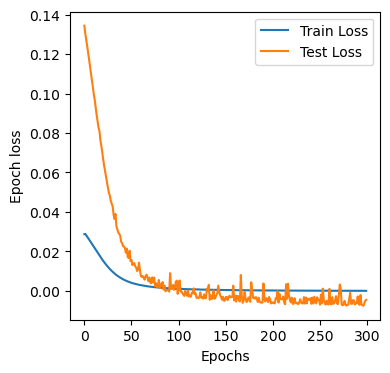

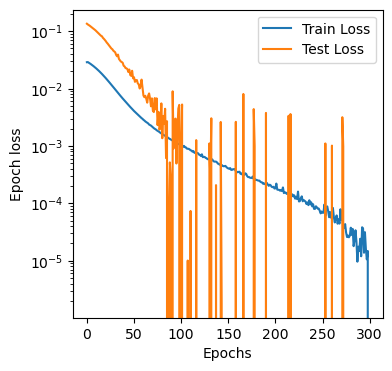

latent_dim: 10


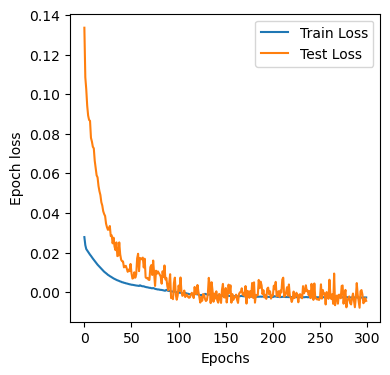

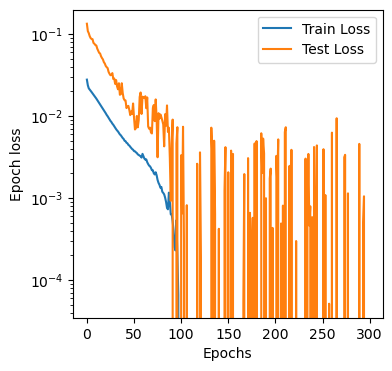

latent_dim: 16


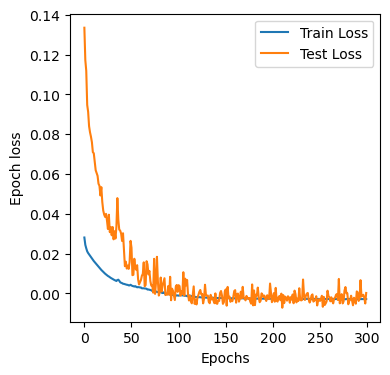

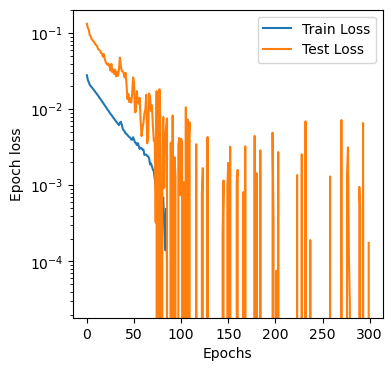

In [9]:
latent_dims = [2, 3, 6, 8, 10, 16]
n_epochs = 300
J_train = []
J_val = []

for latent_dim in latent_dims:

    train_X, test_X, train_params, test_params, train_y, test_y, train_indices, test_indices =train_test_split(X, params, y, indices, test_size=0.2, random_state=24)


    train_dataset = TrainDataset(train_X, train_params, train_y, transform = None)
    test_dataset = TrainDataset(test_X, test_params, test_y, transform = None)
    custom_nn = ICCDNet(output_dim = latent_dim)  

    print("latent_dim:", latent_dim)                                                                                                           
    model, training_loss, test_loss = train_test_custom_nn_DKL(train_dataset, test_dataset, custom_nn, lr_custom_nn = 0.01, lr_gp = 0.01, num_epochs = n_epochs, plot_loss = True, n_batches = 8)
    J_train.append(training_loss), J_val.append(test_loss)
    plot_training_loss(training_loss, test_loss)
        
               

Analyse train and val loss

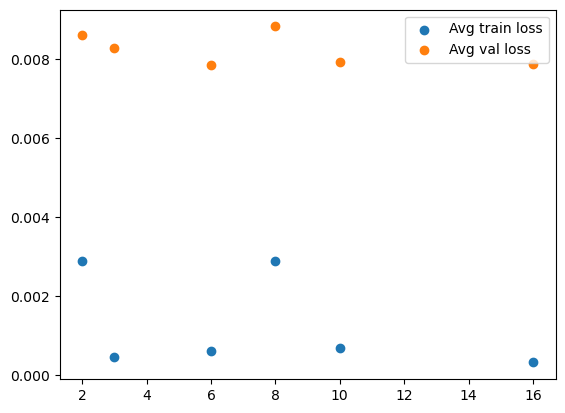

In [10]:
J_train = np.asarray(J_train)
J_val = np.asarray(J_val)

j_train = J_train[:, 0:].mean(axis = -1)
j_val = J_val[:, 0:].mean(axis = -1)

plt.scatter(latent_dims, j_train, label = "Avg train loss")
plt.scatter(latent_dims, j_val, label = "Avg val loss")
plt.legend()
plt.show()

In [26]:
y_means, y_vars = DKL_posterior(model, X)
y_means.shape, y_vars.shape


(torch.Size([381, 1]), torch.Size([381, 1]))

In [14]:
acq_ind, acq_val_max, Acq_vals = acq_fn_EI(y_means, y_vars, train_y)
ind = np.random.choice(acq_ind)

print(ind)

380


## Active learning

Here we choose a smaller training set

In [17]:
train_X, test_X, train_params, test_params, train_y, test_y, train_indices, test_indices =train_test_split(X, params, y, indices, test_size=0.8, random_state=24)
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)
initial_trainsize = train_indices.shape[0]

train_dataset = TrainDataset(train_X, train_params, train_y, transform = None)

torch.Size([76, 1, 50, 40, 40]) torch.Size([76, 1]) torch.Size([305, 1, 50, 40, 40]) torch.Size([305, 1])


In [18]:
n_epochs = 300
n_batches = 4
sample_next_points = 3
beta = 0
lr_custom_nn = 0.01
lr_gp = 0.01

In [19]:
#Set the number of exploration steps
exploration_steps = 10
al_scores = []
ran_scores = []

for i in range(exploration_steps):

    print(f"\n------------------Exploration Step:{i+1} ----------------------- ")
    custom_nn = ICCDNet(output_dim = 10)

    device  = "cuda" if torch.cuda.is_available() else 'cpu'

    train_dataset = TrainDataset(train_X, train_params, train_y, transform = None)
    
    # Contruct the GP surrogate function
    model, training_loss = train_custom_nn_DKL(train_dataset, custom_nn, num_epochs = n_epochs, n_batches = n_batches, 
                                               lr_custom_nn = lr_custom_nn, lr_gp = lr_gp, device= device)
    print("training_loss", training_loss[-1])

    # Calculate the predicted posterior mean and variance
    y_means, y_vars = DKL_posterior(model, X)

    # Calculate the acquisition function using E!
    #acq_ind, acq_val_max, Acq_vals = acq_fn_EI(y_means, y_vars, train_y, index_exclude= train_indices)
    
    #UCB acquisition funtion
    beta = 0.9*beta #beta decay
    acq_ind, acq_val_max, Acq_vals = acq_fn_UCB(y_means, y_vars, beta = beta, index_exclude= train_indices, 
                                                sample_next_points = sample_next_points)

    for ind in acq_ind:

        # Acquire next point

        next_score = score[ind].detach().numpy().squeeze()
        al_scores.append(next_score)

        #randomly acquire
        ran_ind = random.choice(test_indices)
        ran_score = score[ran_ind].detach().numpy().squeeze()
        ran_scores.append(ran_score)

    #         print("Next-index: ",ind)
    #         print("Measured score: ", next_score)

        #Update training data
        train_X, train_y, train_params, train_indices = append_to_train(X, y, params, train_X, train_y, train_params, 
                                                                        train_indices, ind)
        test_indices = np.delete(test_indices, np.where(test_indices == ind))



                                 
    print(train_indices.shape)
    
al_scores = np.asarray(al_scores)
ran_scores = np.asarray(ran_scores)
    


------------------Exploration Step:1 ----------------------- 


training_loss 0.0027694375909623394
(79,)

------------------Exploration Step:2 ----------------------- 


training_loss 0.002736689665785468
(82,)

------------------Exploration Step:3 ----------------------- 


training_loss 0.0027675223414487466
(85,)

------------------Exploration Step:4 ----------------------- 


training_loss 0.002768555854490964
(88,)

------------------Exploration Step:5 ----------------------- 


training_loss 0.0027359892345450313
(91,)

------------------Exploration Step:6 ----------------------- 


training_loss 0.002667565918933682
(94,)

------------------Exploration Step:7 ----------------------- 


training_loss 0.002706902690381738
(97,)

------------------Exploration Step:8 ----------------------- 


training_loss 0.0027727315645275476
(100,)

------------------Exploration Step:9 ----------------------- 


training_loss 0.0027727570788292095
(103,)

------------------Exploration Step:10 ----------------------- 


training_loss 0.0027403478305428573
(106,)


Initial_dataset_score: tensor(93.2249)


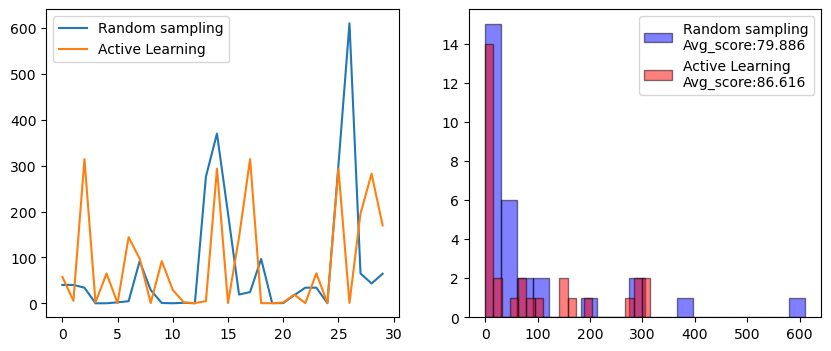

In [21]:
fig, ax = plt.subplots(1, 2, figsize = (10, 4))

print("Initial_dataset_score:", score[train_indices[0:initial_trainsize]].mean())

ax[0].plot(ran_scores, label = 'Random sampling')
ax[0].plot(al_scores, label = 'Active Learning')
ax[0].legend()

ax[1].hist(ran_scores, bins=20, alpha=0.5, label=f'Random sampling\nAvg_score:{ran_scores.mean():.3f}', color='blue', edgecolor='black')
ax[1].hist(al_scores, bins=20, alpha=0.5, label=f'Active Learning\nAvg_score:{al_scores.mean():.3f}', color='red', edgecolor='black')
ax[1].legend()

plt.show()

## Active learning loop

Here we perform active learning experiments across a range of latent_dims

In [16]:
train_X, test_X, train_params, test_params, train_y, test_y, train_indices, test_indices =train_test_split(X, params, y, 
                                                                                                           indices, 
                                                                                                           test_size=0.8, 
                                                                                                           random_state=24)

initial_trainsize = train_indices.shape[0]

train_dataset = TrainDataset(train_X, train_params, train_y, transform = None)

print(len(train_dataset))


n_epochs = 500
n_batches = 4
sample_next_points = 3
beta = 0
lr_custom_nn = 0.01
lr_gp = 0.01
initial_test_fraction = 0.8
random_state = 24


#Set the number of exploration steps
exploration_steps = 10

latent_dims = [3, 6, 10, 16]

 
expt_name = "7_ICCD"
save_folder = os.path.join("data", expt_name)
os.makedirs(save_folder, exist_ok=True)


76



------------------Latent_dim:3	Exploration Step:1 ----------------------- 
76


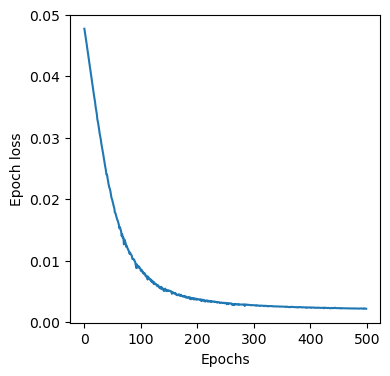

training_loss 0.0021647078648281727
Average pos.mean:0.15118421614170074, Average pos_var: 0.00024833387578837574
(79,)

------------------Latent_dim:3	Exploration Step:2 ----------------------- 
79


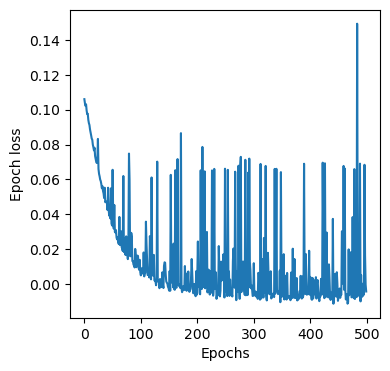

training_loss -0.004223563685469704
Average pos.mean:0.18022708594799042, Average pos_var: 0.00039963811286725104
(82,)

------------------Latent_dim:3	Exploration Step:3 ----------------------- 
82


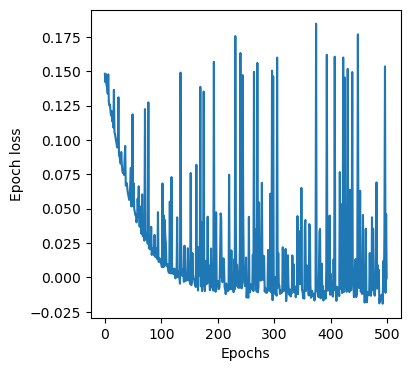

training_loss -0.0007243632177006056
Average pos.mean:0.2008909285068512, Average pos_var: 0.0005667429650202394
(85,)

------------------Latent_dim:3	Exploration Step:4 ----------------------- 
85


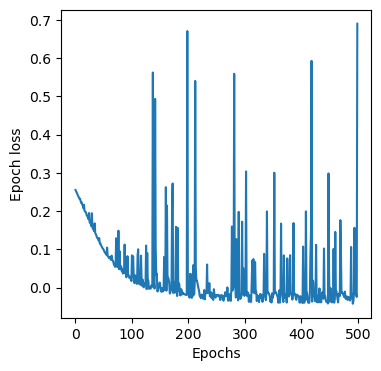

training_loss 0.6901479558294035
Average pos.mean:0.14827166497707367, Average pos_var: 0.0009814603254199028
(88,)

------------------Latent_dim:3	Exploration Step:5 ----------------------- 
88


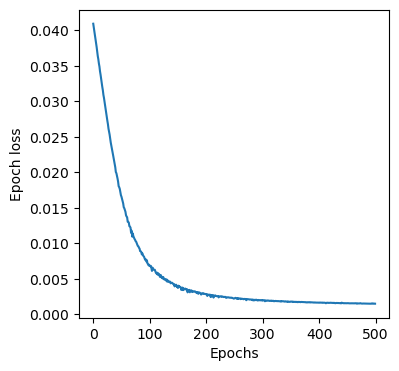

training_loss 0.0014924525765045104
Average pos.mean:0.1497943252325058, Average pos_var: 0.000226368589210324
(91,)

------------------Latent_dim:3	Exploration Step:6 ----------------------- 
91


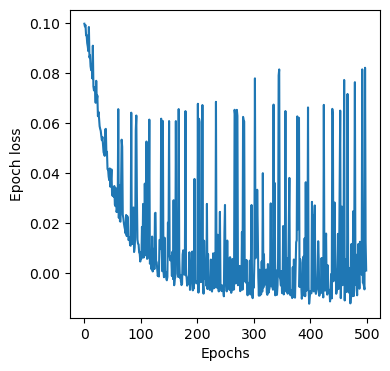

training_loss 0.0011847441232584485
Average pos.mean:0.15943396091461182, Average pos_var: 0.0004369192465674132
(94,)

------------------Latent_dim:3	Exploration Step:7 ----------------------- 
94


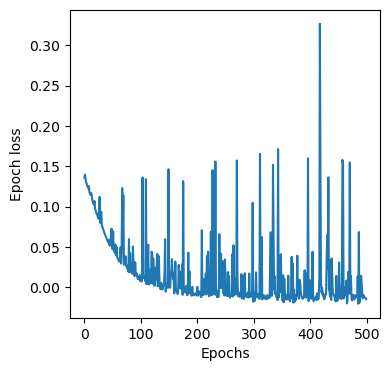

training_loss -0.014781968987623743
Average pos.mean:0.1260920614004135, Average pos_var: 0.000588133349083364
(97,)

------------------Latent_dim:3	Exploration Step:8 ----------------------- 
97


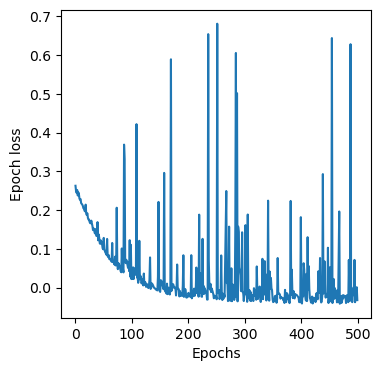

training_loss -0.032106950523055136
Average pos.mean:0.14719024300575256, Average pos_var: 0.0011632851092144847
(100,)

------------------Latent_dim:3	Exploration Step:9 ----------------------- 
100


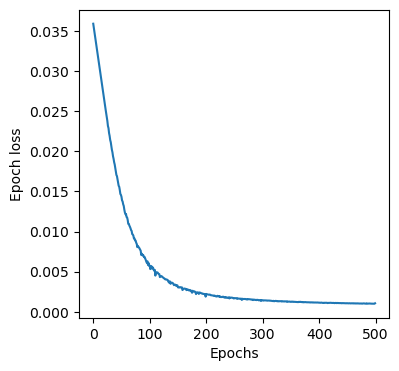

training_loss 0.001068081885535679
Average pos.mean:0.1615549921989441, Average pos_var: 0.00020054186461493373
(103,)

------------------Latent_dim:3	Exploration Step:10 ----------------------- 
103


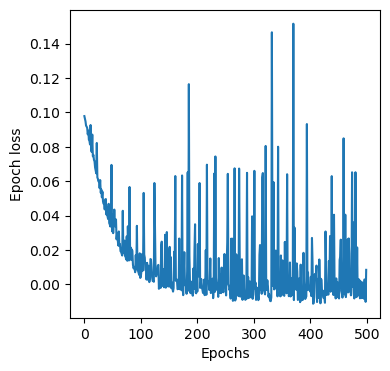

training_loss 0.008409226385784155
Average pos.mean:0.17032931745052338, Average pos_var: 0.000465003598947078
(106,)
Intitial_dataset_score: tensor(93.2249)


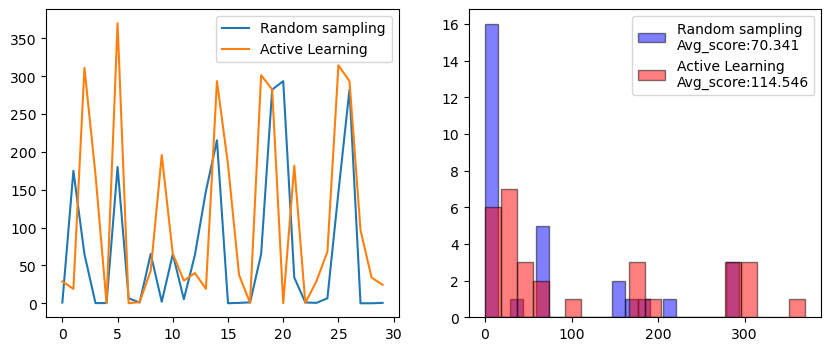


------------------Latent_dim:6	Exploration Step:1 ----------------------- 
76


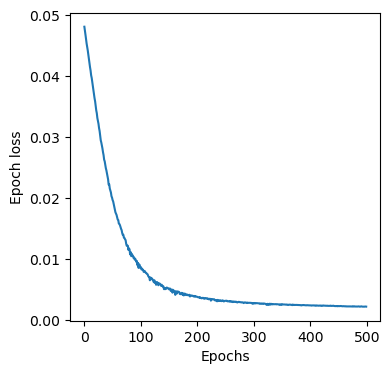

training_loss 0.002156799654666958
Average pos.mean:0.15041780471801758, Average pos_var: 0.0002978407428599894
(79,)

------------------Latent_dim:6	Exploration Step:2 ----------------------- 
79


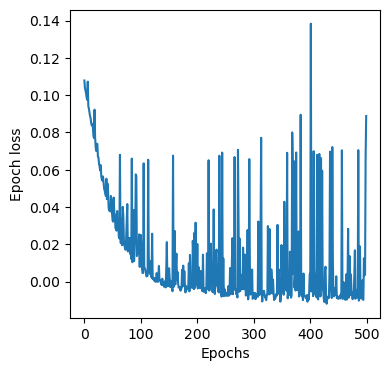

training_loss 0.08881243926280705
Average pos.mean:0.17668592929840088, Average pos_var: 0.0003878252173308283
(82,)

------------------Latent_dim:6	Exploration Step:3 ----------------------- 
82


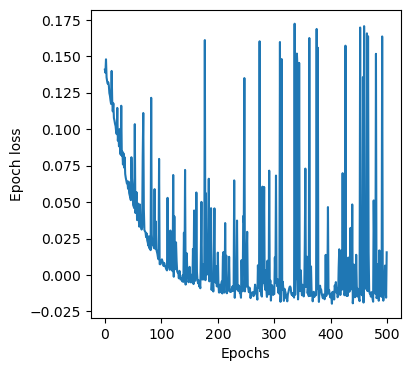

training_loss 0.015565423527352565
Average pos.mean:0.14128515124320984, Average pos_var: 0.0005703223287127912
(85,)

------------------Latent_dim:6	Exploration Step:4 ----------------------- 
85


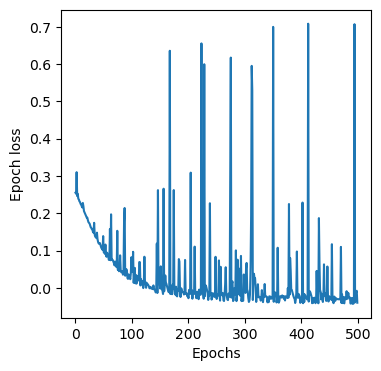

training_loss -0.04003227938621941
Average pos.mean:0.16153189539909363, Average pos_var: 0.0009244047687388957
(88,)

------------------Latent_dim:6	Exploration Step:5 ----------------------- 
88


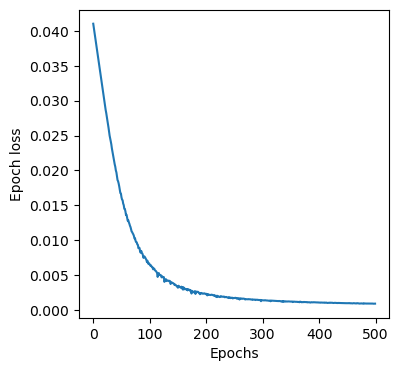

training_loss 0.0009224566766010835
Average pos.mean:0.1401372253894806, Average pos_var: 0.00023064306878950447
(91,)

------------------Latent_dim:6	Exploration Step:6 ----------------------- 
91


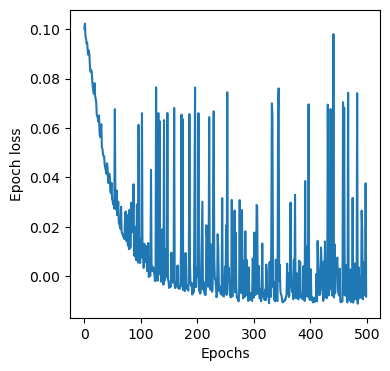

training_loss -0.008137238384479353
Average pos.mean:0.15170659124851227, Average pos_var: 0.00041800193139351904
(94,)

------------------Latent_dim:6	Exploration Step:7 ----------------------- 
94


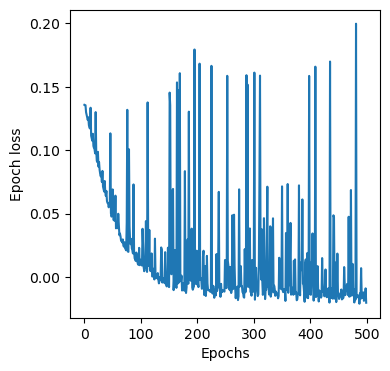

training_loss -0.020322357473291242
Average pos.mean:0.1334511786699295, Average pos_var: 0.0005597096751444042
(97,)

------------------Latent_dim:6	Exploration Step:8 ----------------------- 
97


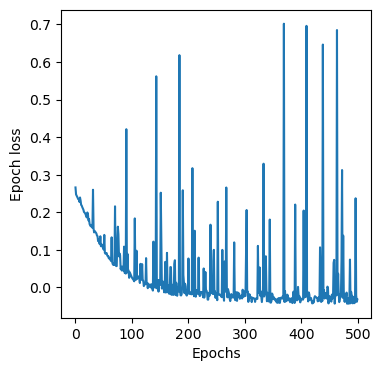

training_loss -0.0320703600582504
Average pos.mean:0.17837348580360413, Average pos_var: 0.0010056759929284453
(100,)

------------------Latent_dim:6	Exploration Step:9 ----------------------- 
100


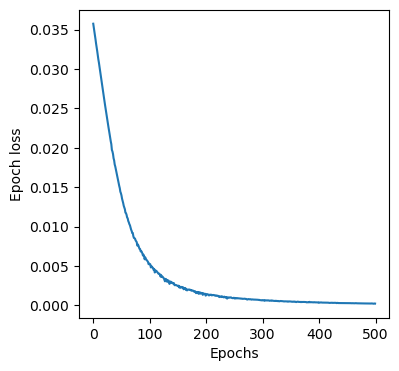

training_loss 0.00024302746944501188
Average pos.mean:0.13151966035366058, Average pos_var: 0.00019513849110808223
(103,)

------------------Latent_dim:6	Exploration Step:10 ----------------------- 
103


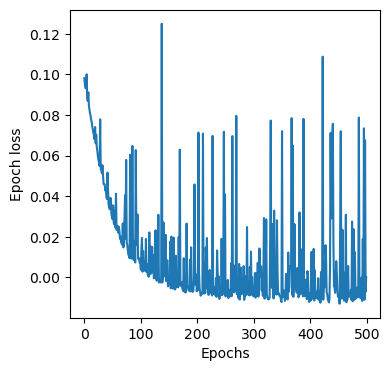

training_loss 0.00015930236384430625
Average pos.mean:0.14625297486782074, Average pos_var: 0.00044021353824064136
(106,)
Intitial_dataset_score: tensor(93.2249)


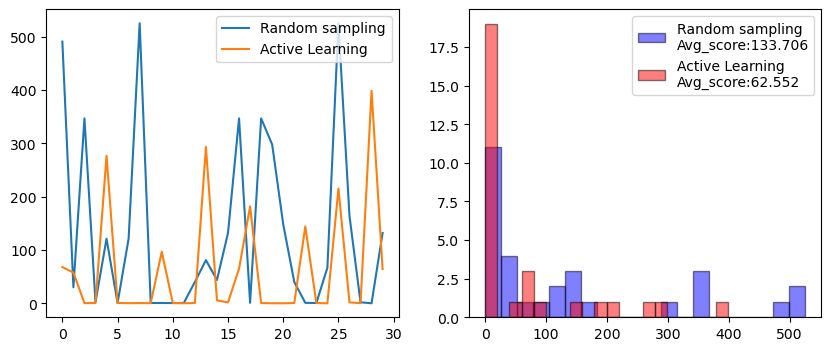


------------------Latent_dim:10	Exploration Step:1 ----------------------- 
76


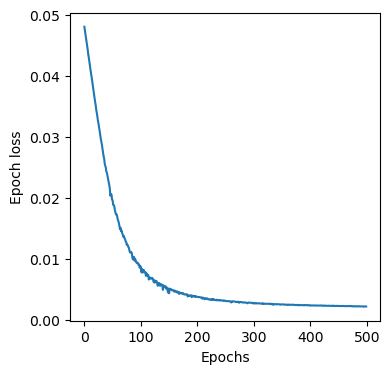

training_loss 0.002174312822215545
Average pos.mean:0.1544940322637558, Average pos_var: 0.0002537729451432824
(79,)

------------------Latent_dim:10	Exploration Step:2 ----------------------- 
79


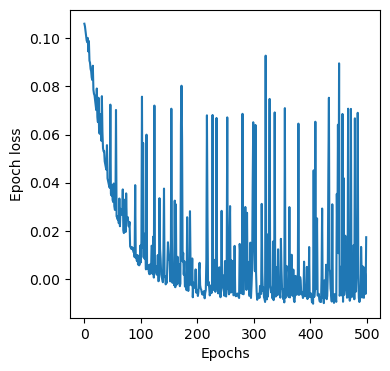

training_loss 0.01731976080507464
Average pos.mean:0.14689968526363373, Average pos_var: 0.00043482831097207963
(82,)

------------------Latent_dim:10	Exploration Step:3 ----------------------- 
82


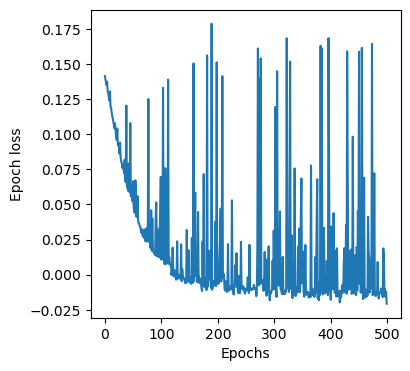

training_loss -0.020640338675230224
Average pos.mean:0.12183316797018051, Average pos_var: 0.0005525228334590793
(85,)

------------------Latent_dim:10	Exploration Step:4 ----------------------- 
85


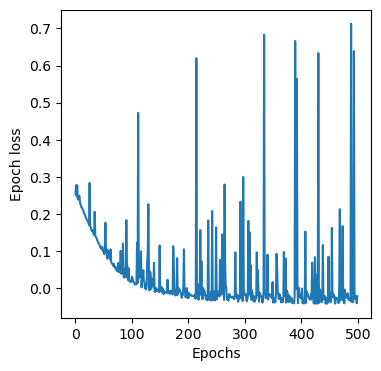

training_loss -0.02123453497976391
Average pos.mean:0.14408442378044128, Average pos_var: 0.0017284891800954938
(88,)

------------------Latent_dim:10	Exploration Step:5 ----------------------- 
88


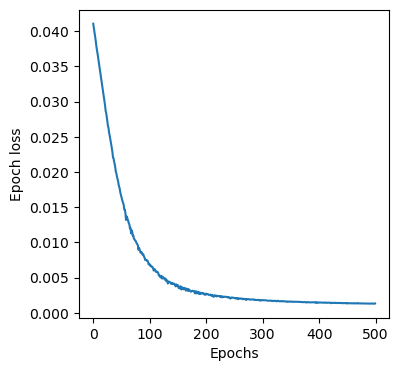

training_loss 0.0013168909318772518
Average pos.mean:0.15092183649539948, Average pos_var: 0.0002263861388200894
(91,)

------------------Latent_dim:10	Exploration Step:6 ----------------------- 
91


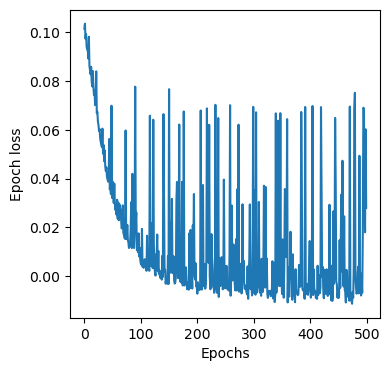

training_loss 0.028083764521427475
Average pos.mean:0.20509907603263855, Average pos_var: 0.0006781274569220841
(94,)

------------------Latent_dim:10	Exploration Step:7 ----------------------- 
94


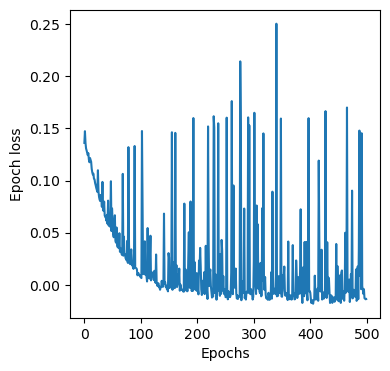

training_loss -0.013640827471958683
Average pos.mean:0.11512648314237595, Average pos_var: 0.0008148808847181499
(97,)

------------------Latent_dim:10	Exploration Step:8 ----------------------- 
97


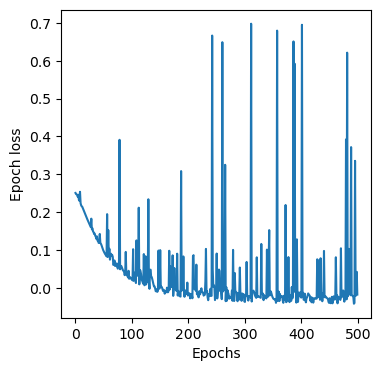

training_loss -0.01747077668623879
Average pos.mean:0.1627446860074997, Average pos_var: 0.0012806126615032554
(100,)

------------------Latent_dim:10	Exploration Step:9 ----------------------- 
100


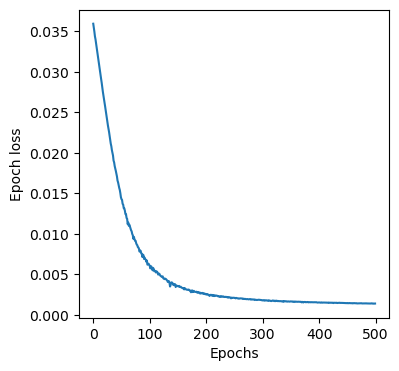

training_loss 0.0014034471402793102
Average pos.mean:0.14195911586284637, Average pos_var: 0.0002145707403542474
(103,)

------------------Latent_dim:10	Exploration Step:10 ----------------------- 
103


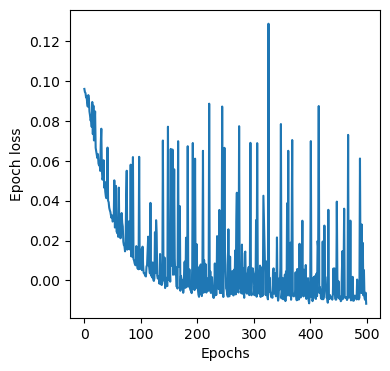

training_loss -0.011689557403302431
Average pos.mean:0.12330939620733261, Average pos_var: 0.00043853596434928477
(106,)
Intitial_dataset_score: tensor(93.2249)


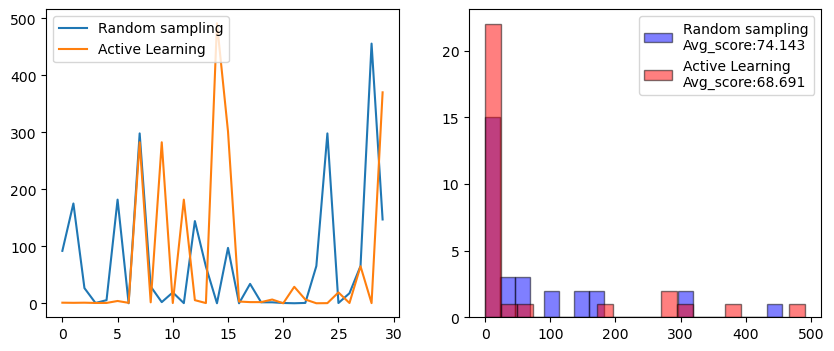


------------------Latent_dim:16	Exploration Step:1 ----------------------- 
76


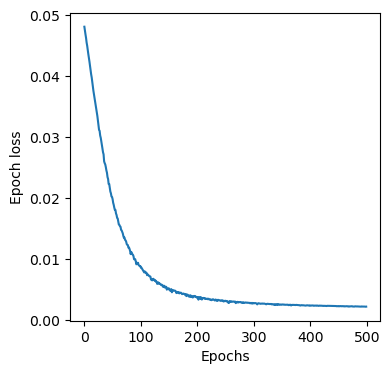

training_loss 0.0021701990843416073
Average pos.mean:0.15263938903808594, Average pos_var: 0.0002660630561877042
(79,)

------------------Latent_dim:16	Exploration Step:2 ----------------------- 
79


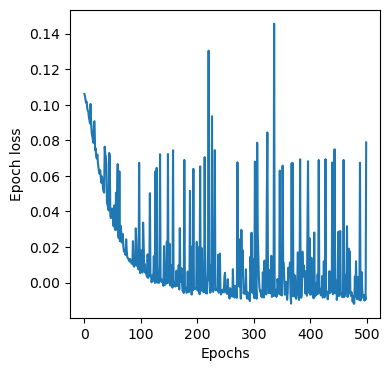

training_loss 0.0788589386845677
Average pos.mean:0.14833131432533264, Average pos_var: 0.0004203913558740169
(82,)

------------------Latent_dim:16	Exploration Step:3 ----------------------- 
82


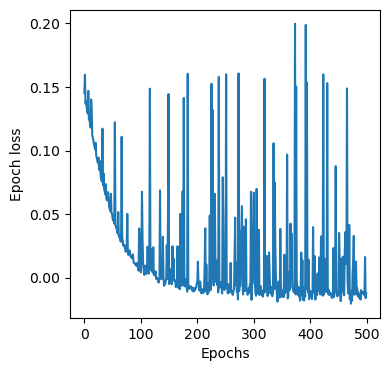

training_loss -0.0120967662631924
Average pos.mean:0.1469259411096573, Average pos_var: 0.0005541531136259437
(85,)

------------------Latent_dim:16	Exploration Step:4 ----------------------- 
85


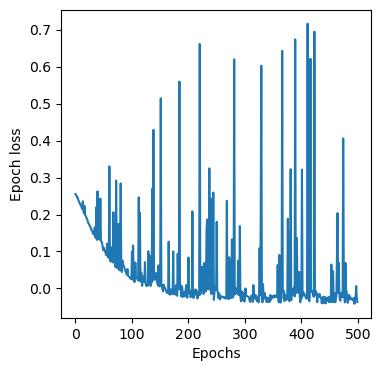

training_loss -0.0367384425579348
Average pos.mean:0.14483311772346497, Average pos_var: 0.0010852748528122902
(88,)

------------------Latent_dim:16	Exploration Step:5 ----------------------- 
88


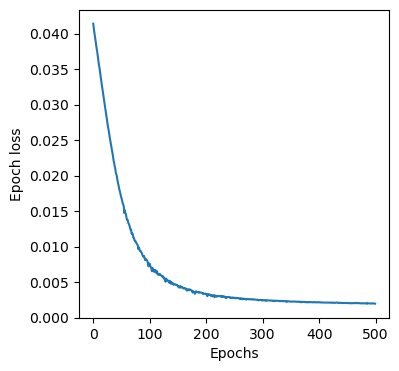

training_loss 0.0019683856590799065
Average pos.mean:0.15351919829845428, Average pos_var: 0.0002457850205246359
(91,)

------------------Latent_dim:16	Exploration Step:6 ----------------------- 
91


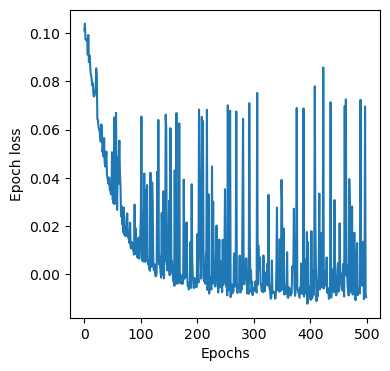

training_loss -0.009512478044618836
Average pos.mean:0.15650834143161774, Average pos_var: 0.0005059274844825268
(94,)

------------------Latent_dim:16	Exploration Step:7 ----------------------- 
94


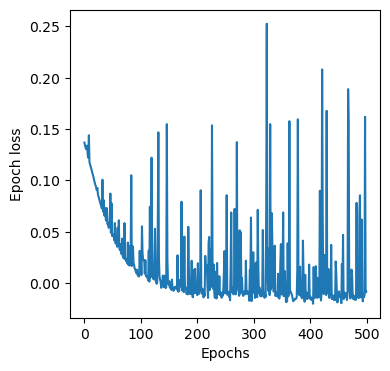

training_loss -0.008361389042817415
Average pos.mean:0.1572692096233368, Average pos_var: 0.0005653607659041882
(97,)

------------------Latent_dim:16	Exploration Step:8 ----------------------- 
97


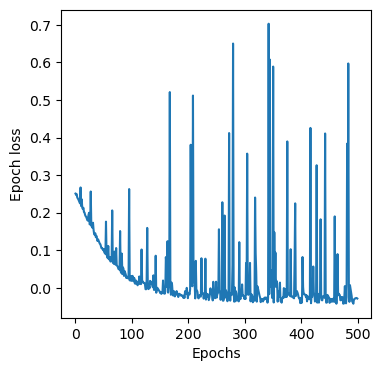

training_loss -0.028410799549397396
Average pos.mean:0.11939536035060883, Average pos_var: 0.0010825549252331257
(100,)

------------------Latent_dim:16	Exploration Step:9 ----------------------- 
100


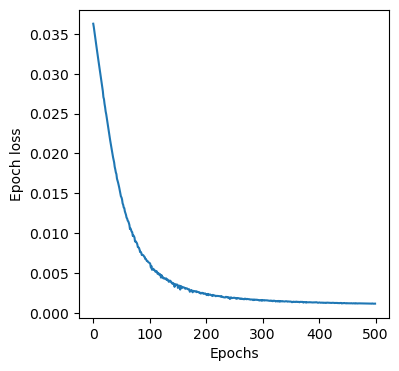

training_loss 0.0011556020343182513
Average pos.mean:0.14725883305072784, Average pos_var: 0.000242848094785586
(103,)

------------------Latent_dim:16	Exploration Step:10 ----------------------- 
103


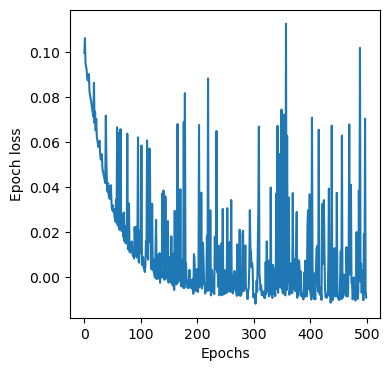

training_loss -0.009079765873004122
Average pos.mean:0.15549609065055847, Average pos_var: 0.00042194221168756485
(106,)
Intitial_dataset_score: tensor(93.2249)


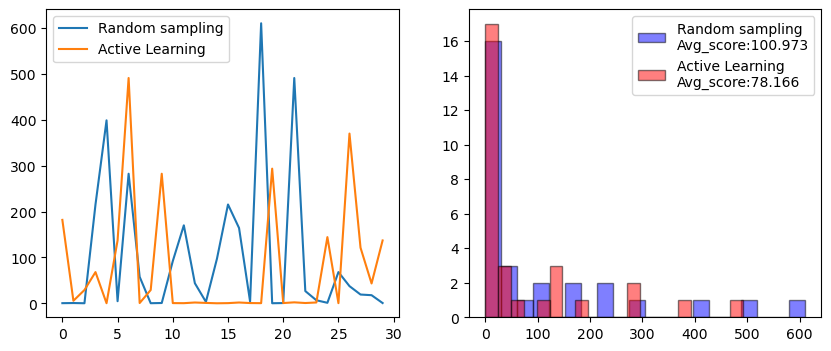

In [17]:

for latent_dim in latent_dims:
    
    # Initialize trainset

    train_X, test_X, train_params, test_params, train_y, test_y, train_indices, test_indices =train_test_split(X, params, y, 
                                                                                                           indices, 
                                                                                                           test_size=initial_test_fraction, 
                                                                                                           random_state = random_state)
    
    initial_trainsize = train_indices.shape[0]

    train_dataset = TrainDataset(train_X, train_params, train_y, transform = None)
    
    
    al_scores = []
    ran_scores = []

    for i in range(exploration_steps):

        print(f"\n------------------Latent_dim:{latent_dim}\tExploration Step:{i+1} ----------------------- ")

        custom_nn = ICCDNet(output_dim = latent_dim)

        device  = "cuda" if torch.cuda.is_available() else 'cpu'

        
        train_dataset = TrainDataset(train_X, train_params, train_y, transform = None)
        print(len(train_dataset))

        # Contruct the GP surrogate function
        model, training_loss = train_custom_nn_DKL(train_dataset, custom_nn, num_epochs = n_epochs, n_batches = n_batches, 
                                               lr_custom_nn = lr_custom_nn, lr_gp = lr_gp, device= device, plot_loss = True)
        
      

        print("training_loss", training_loss[-1])

        # Calculate the predicted posterior mean and variance
        y_means, y_vars = DKL_posterior(model, X)

        print(f"Average pos.mean:{y_means.mean()}, Average pos_var: {y_vars.mean()}")

        # Calculate the acquisition function
        #acq_ind, acq_val_max, Acq_vals = acq_fn_EI(y_means, y_vars, train_y, index_exclude= train_indices)

        
        acq_ind, acq_val_max, Acq_vals = acq_fn_UCB(y_means, y_vars, beta = beta, index_exclude= train_indices, 
                                                    sample_next_points = sample_next_points)

        # best estimates
        #X_best_train, X_best_pred = best_mean_estimate(train_X, train_y, X, y_means)


        for ind in acq_ind:

            # Acquire next point

            next_score = score[ind].detach().numpy().squeeze()
            al_scores.append(next_score)

            #randomly acquire
            ran_ind = random.choice(test_indices)
            ran_score = score[ran_ind].detach().numpy().squeeze()
            ran_scores.append(ran_score)

            #Update training data
            train_X, train_y, train_params, train_indices = append_to_train(X, y, params, train_X, train_y, train_params, 
                                                                            train_indices, ind)
            test_indices = np.delete(test_indices, np.where(test_indices == ind))



        print(train_indices.shape)

    al_scores = np.asarray(al_scores)
    ran_scores = np.asarray(ran_scores)
    
    
    # Save trainindices
    
    np.savetxt(os.path.join(save_folder, f'train_indices_ldim{latent_dim}.txt'), train_indices.T)
    
    
    # Savefigure
    fig, ax = plt.subplots(1, 2, figsize = (10, 4))

    print("Intitial_dataset_score:", score[train_indices[0:initial_trainsize]].mean())

    ax[0].plot(ran_scores, label = 'Random sampling')
    ax[0].plot(al_scores, label = 'Active Learning')
    ax[0].legend()

    ax[1].hist(ran_scores, bins=20, alpha=0.5, label=f'Random sampling\nAvg_score:{ran_scores.mean():.3f}', color='blue', edgecolor='black')
    ax[1].hist(al_scores, bins=20, alpha=0.5, label=f'Active Learning\nAvg_score:{al_scores.mean():.3f}', color='red', edgecolor='black')
    ax[1].legend()

    plt.savefig(os.path.join(save_folder, f'scorehist_ldim{latent_dim}.jpg'), bbox_inches = 'tight')
    plt.show()
    
    
    

# 2. DKL with RCNN

In [5]:

datafile = 'data/PLD data.json'

# Get the dataset, for RCNN, the images_sequence is shaped as: (batch_size=127, seq_len=50, classes =1, width=40, height=40)
dataset1 = ICCDDataset(datafile, image_for_rcnn = True)


# Define the transform1
transform = transforms.RandomAffine(180,
                                    translate=(0.1,0.1),
                                    shear=10,
                                    scale=(0.8,1.2))
# Define the dataset with the transform
dataset2 = ICCDDataset(datafile, transform = transform, image_for_rcnn = True)


# Define the transform with Gaussian noise
transform_with_noise = transforms.Compose([
    transforms.RandomAffine(180, translate=(0.1, 0.1), shear=10, scale=(0.8, 1.2)),
    AddGaussianNoise(mean=0.0, std=0.1)
])

# Define the noise for parameters
param_noise = AddGaussianNoise(mean=0.0, std=0.1)

# Define the dataset with the transform and noise
dataset3 = ICCDDataset(datafile, transform=transform_with_noise, params_noise=param_noise, image_for_rcnn = True)


# Combine the datsets
dataset = ConcatDataset([dataset1, dataset2, dataset3])



In [6]:
dataloader = DataLoader(dataset, batch_size=1, shuffle=False)
X, orig_params, score,_ = extract_data(dataloader, norm = False)
X, params, y, indices = extract_data(dataloader)

In [7]:
from sklearn.model_selection import train_test_split
train_X, test_X, train_params, test_params, train_y, test_y, train_indices, test_indices =train_test_split(X, params, y, indices, test_size=0.2, random_state=24)
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

train_dataset = TrainDataset(train_X, train_params, train_y, transform = None)
test_dataset = TrainDataset(test_X, test_params, test_y, transform = None)

torch.Size([304, 50, 1, 40, 40]) torch.Size([304, 1]) torch.Size([77, 50, 1, 40, 40]) torch.Size([77, 1])


## Single step training

In [ ]:
custom_nn = RCNN_FeatureExtractor(output_dim = 3)

latent_dim: 2


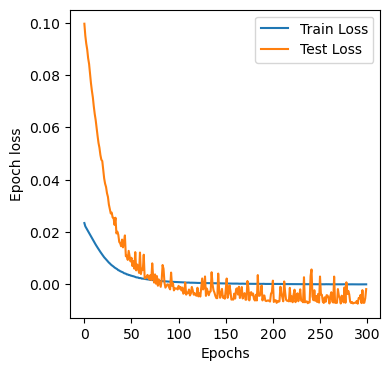

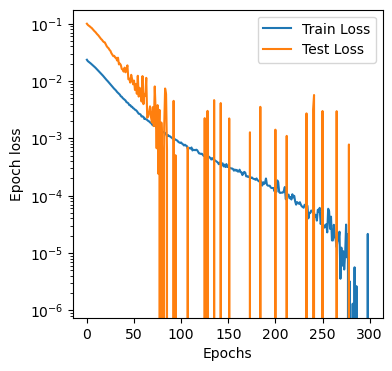

latent_dim: 3


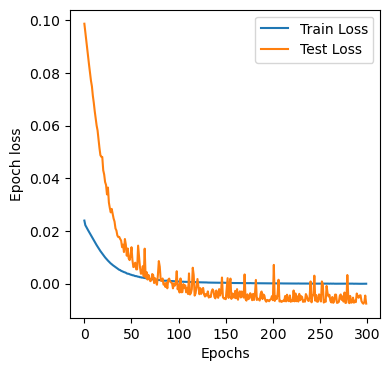

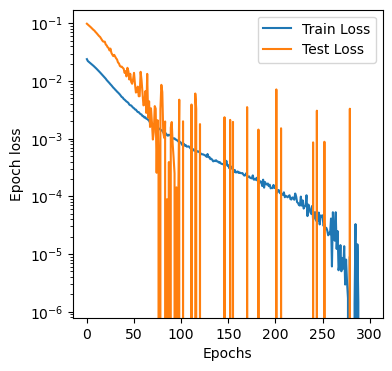

latent_dim: 6


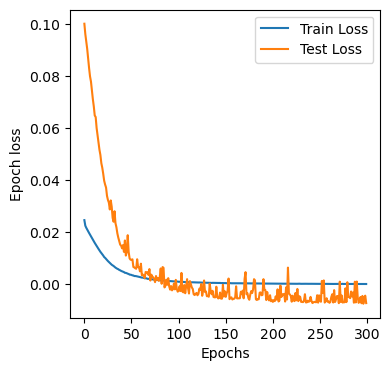

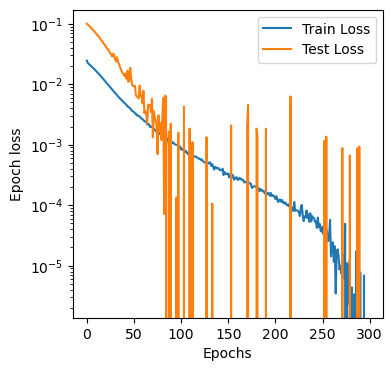

latent_dim: 8


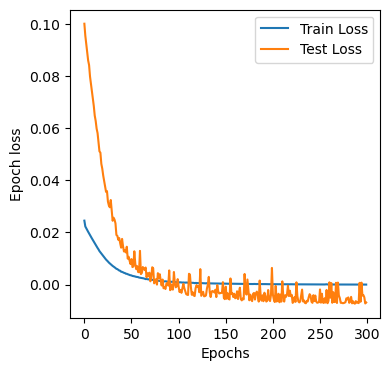

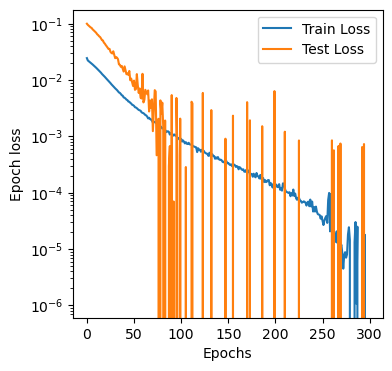

latent_dim: 10


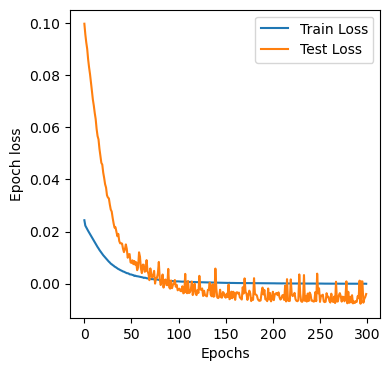

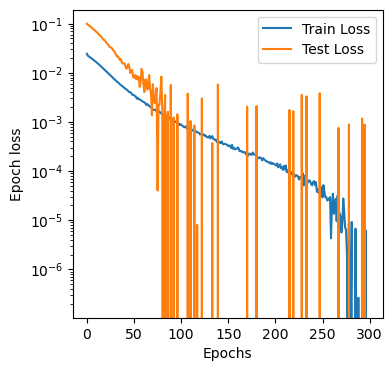

latent_dim: 16


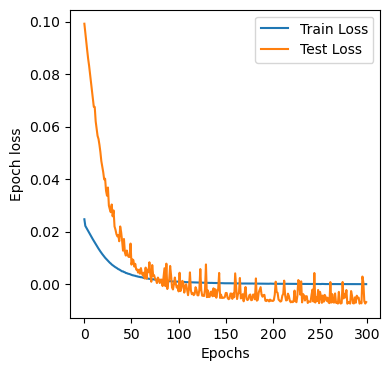

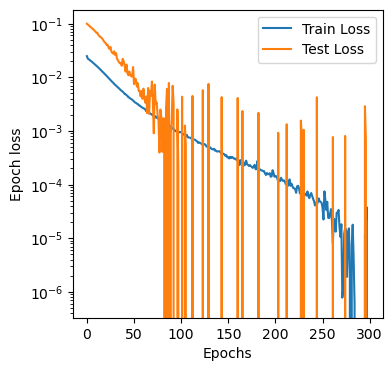

In [ ]:
latent_dims = [2, 3, 6, 8, 10, 16] # Try different latent dims
n_epochs = 300
J_train = []
J_val = []

for latent_dim in latent_dims:

    train_X, test_X, train_params, test_params, train_y, test_y, train_indices, test_indices =train_test_split(X, params, y, indices, test_size=0.2, random_state=24)


    train_dataset = TrainDataset(train_X, train_params, train_y, transform = None)
    test_dataset = TrainDataset(test_X, test_params, test_y, transform = None)
    custom_nn = RCNN_FeatureExtractor(output_dim = latent_dim) 

    print("latent_dim:", latent_dim)                                                                                                           
    model, training_loss, test_loss = train_test_custom_nn_DKL(train_dataset, test_dataset, custom_nn, lr_custom_nn = 0.01, lr_gp = 0.01, num_epochs = n_epochs, plot_loss = True, n_batches = 8)
    J_train.append(training_loss), J_val.append(test_loss)
    plot_training_loss(training_loss, test_loss)
        
               

Analyse train and val loss

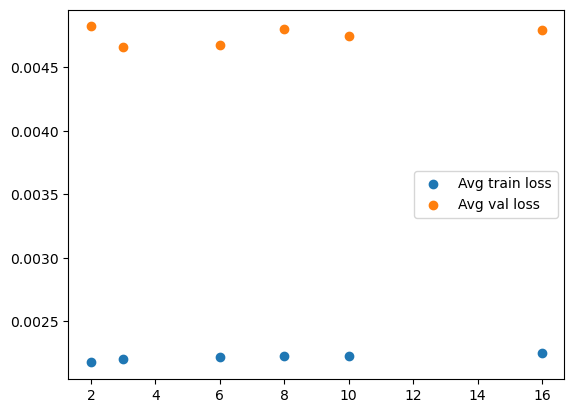

In [30]:
J_train = np.asarray(J_train)
J_val = np.asarray(J_val)

j_train = J_train[:, 0:].mean(axis = -1)
j_val = J_val[:, 0:].mean(axis = -1)

plt.scatter(latent_dims, j_train, label = "Avg train loss")
plt.scatter(latent_dims, j_val, label = "Avg val loss")
plt.legend()
plt.show()

## Active Learning - using RCNN

Active learning for a single latent dim.

In [12]:
train_X, test_X, train_params, test_params, train_y, test_y, train_indices, test_indices =train_test_split(X, params, y, indices, test_size=0.8, random_state=24)
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)
initial_trainsize = train_indices.shape[0]

train_dataset = TrainDataset(train_X, train_params, train_y, transform = None)

torch.Size([76, 50, 1, 40, 40]) torch.Size([76, 1]) torch.Size([305, 50, 1, 40, 40]) torch.Size([305, 1])


In [13]:
n_epochs = 300
n_batches = 4
sample_next_points = 3
beta = 0
lr_custom_nn = 0.01
lr_gp = 0.01

In [ ]:
#Set the number of exploration steps
exploration_steps = 10
al_scores = []
ran_scores = []

for i in range(exploration_steps):

    print(f"\n------------------Exploration Step:{i+1} ----------------------- ")
    custom_nn = RCNN_FeatureExtractor(output_dim = 10)

    device  = "cuda" if torch.cuda.is_available() else 'cpu'

    train_dataset = TrainDataset(train_X, train_params, train_y, transform = None)

    # Contruct the GP surrogate function
    model, training_loss = train_custom_nn_DKL(train_dataset, custom_nn, num_epochs = n_epochs, n_batches = n_batches, 
                                               lr_custom_nn = lr_custom_nn, lr_gp = lr_gp, device= device)
    print("training_loss", training_loss[-1])

    # Calculate the predicted posterior mean and variance
    y_means, y_vars = DKL_posterior(model, X)

    # Calculate the acquisition function using E!
    #acq_ind, acq_val_max, Acq_vals = acq_fn_EI(y_means, y_vars, train_y, index_exclude= train_indices)
    
    #UCB acquisition funtion
    beta = 0.9*beta #beta decay
    acq_ind, acq_val_max, Acq_vals = acq_fn_UCB(y_means, y_vars, beta = beta, index_exclude= train_indices, 
                                                sample_next_points = sample_next_points)

    for ind in acq_ind:

        # Acquire next point

        next_score = score[ind].detach().numpy().squeeze()
        al_scores.append(next_score)

        #randomly acquire
        ran_ind = random.choice(test_indices)
        ran_score = score[ran_ind].detach().numpy().squeeze()
        ran_scores.append(ran_score)

    #         print("Next-index: ",ind)
    #         print("Measured score: ", next_score)

                #Update training data
        train_X, train_y, train_params, train_indices = append_to_train(X, y, params, train_X, train_y, train_params, 
                                                                        train_indices, ind)
        test_indices = np.delete(test_indices, np.where(test_indices == ind))


                                 
    print(train_indices.shape)
    
al_scores = np.asarray(al_scores)
ran_scores = np.asarray(ran_scores)
    


------------------Exploration Step:1 ----------------------- 


training_loss 0.002819389672929851
(79,)

------------------Exploration Step:2 ----------------------- 


training_loss 0.002693787847474254
(82,)

------------------Exploration Step:3 ----------------------- 


training_loss 0.0029936706627001278
(85,)

------------------Exploration Step:4 ----------------------- 


training_loss 0.0028563041162989007
(88,)

------------------Exploration Step:5 ----------------------- 


training_loss 0.0028533497342809314
(91,)

------------------Exploration Step:6 ----------------------- 


training_loss 0.00310794379620749
(94,)

------------------Exploration Step:7 ----------------------- 


training_loss 0.0030281914389111595
(97,)

------------------Exploration Step:8 ----------------------- 


training_loss 0.0030291594340002112
(100,)

------------------Exploration Step:9 ----------------------- 


training_loss 0.002971927507066115
(103,)

------------------Exploration Step:10 ----------------------- 


training_loss 0.0030943958692943403
(106,)


Initial_dataset_score: tensor(93.2249)


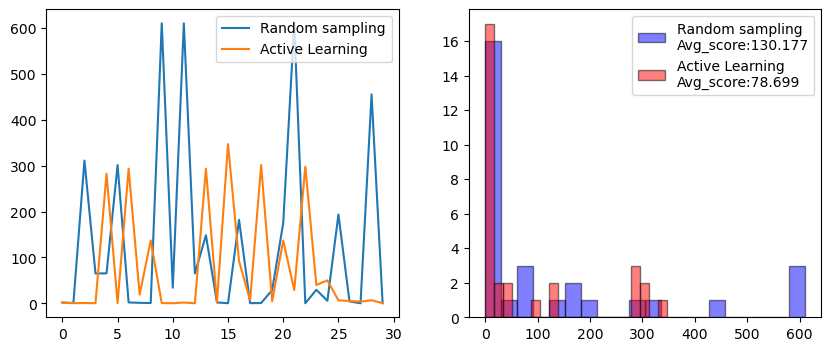

In [15]:
fig, ax = plt.subplots(1, 2, figsize = (10, 4))

print("Initial_dataset_score:", score[train_indices[0:initial_trainsize]].mean())

ax[0].plot(ran_scores, label = 'Random sampling')
ax[0].plot(al_scores, label = 'Active Learning')
ax[0].legend()

ax[1].hist(ran_scores, bins=20, alpha=0.5, label=f'Random sampling\nAvg_score:{ran_scores.mean():.3f}', color='blue', edgecolor='black')
ax[1].hist(al_scores, bins=20, alpha=0.5, label=f'Active Learning\nAvg_score:{al_scores.mean():.3f}', color='red', edgecolor='black')
ax[1].legend()

plt.show()

In [ ]:
plot_train_series(train_indices, orig_params, score)

In [ ]:
plot_train_hist(train_indices, orig_params)

In [ ]:
plot_mean_map(y_means, train_indices, orig_params, score)

Independly, use the DKL sampled points to map the params to the score using an independent GP regression

In [ ]:
train_params = params[train_indices]

y_GPmean, _, _ = parameter_mapping(train_params, train_y, orig_params, param_divs = [10, 10, 10, 10], plot_GP = True)


## Active learning loop - Using LSTMCNN

Here we implement active learning over a range of latent_dims

In [ ]:
train_X, test_X, train_params, test_params, train_y, test_y, train_indices, test_indices =train_test_split(X, params, y, 
                                                                                                           indices, 
                                                                                                           test_size=0.8, 
                                                                                                           random_state=24)

initial_trainsize = train_indices.shape[0]

train_dataset = TrainDataset(train_X, train_params, train_y, transform = None)

print(len(train_dataset))


n_epochs = 500
n_batches = 4
sample_next_points = 3
beta = 0
lr_custom_nn = 0.01
lr_gp = 0.01
initial_test_fraction = 0.8
random_state = 24


#Set the number of exploration steps
exploration_steps = 10

latent_dims = [3, 6, 10, 16]  #Try different latent dims

 
expt_name = "8_LSTMCNN"
save_folder = os.path.join("data", expt_name)
os.makedirs(save_folder, exist_ok=True)

76



------------------Latent_dim:3	Exploration Step:1 ----------------------- 
76


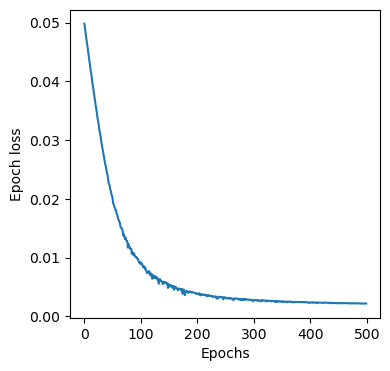

training_loss 0.0021983078579581065
Average pos.mean:0.15853187441825867, Average pos_var: 0.0003639751230366528
(79,)

------------------Latent_dim:3	Exploration Step:2 ----------------------- 
79


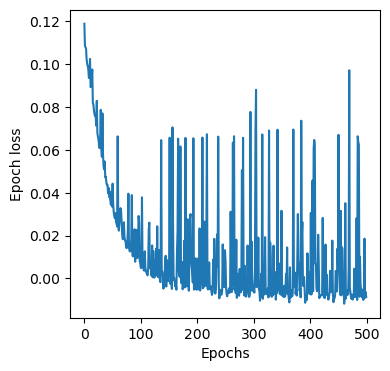

training_loss -0.008731363869926612
Average pos.mean:0.1502811312675476, Average pos_var: 0.00047262932639569044
(82,)

------------------Latent_dim:3	Exploration Step:3 ----------------------- 
82


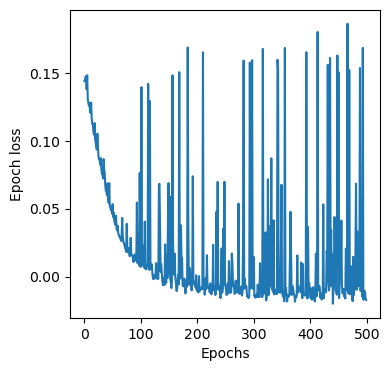

training_loss -0.017296806066129766
Average pos.mean:0.11878790706396103, Average pos_var: 0.0005772809963673353
(85,)

------------------Latent_dim:3	Exploration Step:4 ----------------------- 
85


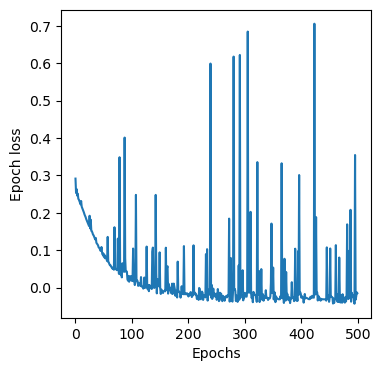

training_loss -0.01472457363298057
Average pos.mean:0.16938291490077972, Average pos_var: 0.0008146791951730847
(88,)

------------------Latent_dim:3	Exploration Step:5 ----------------------- 
88


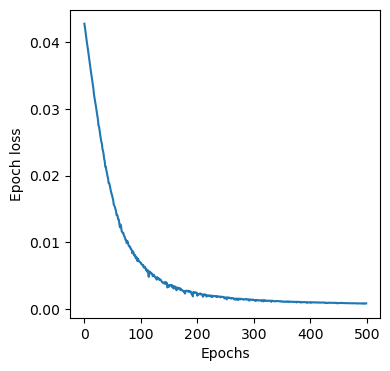

training_loss 0.0008363984688844926
Average pos.mean:0.13305848836898804, Average pos_var: 0.00035059257061220706
(91,)

------------------Latent_dim:3	Exploration Step:6 ----------------------- 
91


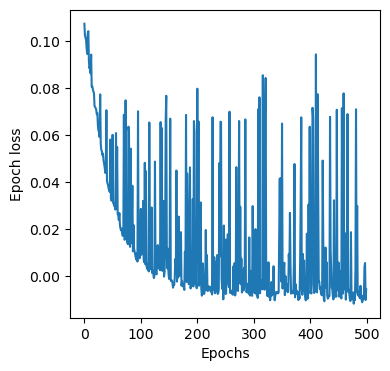

training_loss -0.005707518156684695
Average pos.mean:0.14920026063919067, Average pos_var: 0.0005024736747145653
(94,)

------------------Latent_dim:3	Exploration Step:7 ----------------------- 
94


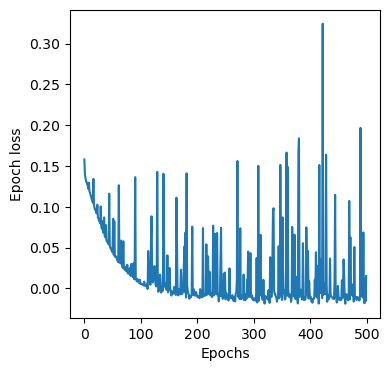

training_loss 0.015135071439798411
Average pos.mean:0.14340034127235413, Average pos_var: 0.0006215304601937532
(97,)

------------------Latent_dim:3	Exploration Step:8 ----------------------- 
97


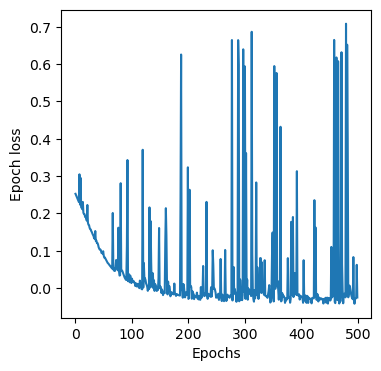

training_loss -0.02520250354705835
Average pos.mean:0.14046604931354523, Average pos_var: 0.0011529503390192986
(100,)

------------------Latent_dim:3	Exploration Step:9 ----------------------- 
100


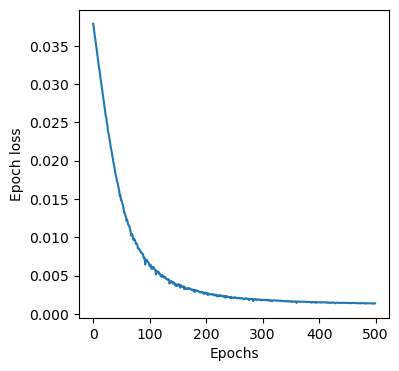

training_loss 0.0013783052783047098
Average pos.mean:0.14104460179805756, Average pos_var: 0.0003479217120911926
(103,)

------------------Latent_dim:3	Exploration Step:10 ----------------------- 
103


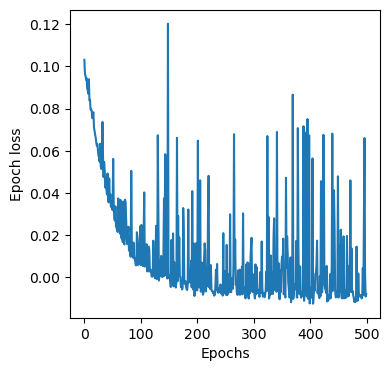

training_loss -0.008055447929513522
Average pos.mean:0.1737888902425766, Average pos_var: 0.0004591289034578949
(106,)
Intitial_dataset_score: tensor(93.2249)


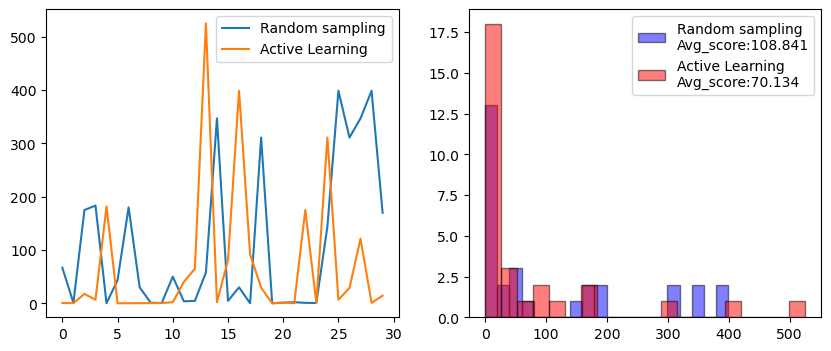


------------------Latent_dim:6	Exploration Step:1 ----------------------- 
76


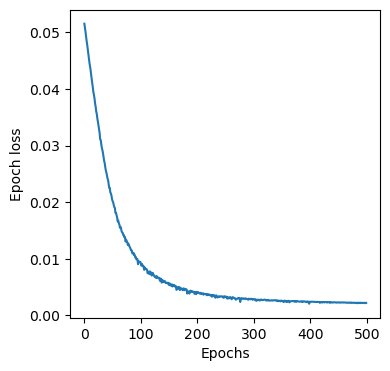

training_loss 0.002209782917618085
Average pos.mean:0.1511135995388031, Average pos_var: 0.0004892225842922926
(79,)

------------------Latent_dim:6	Exploration Step:2 ----------------------- 
79


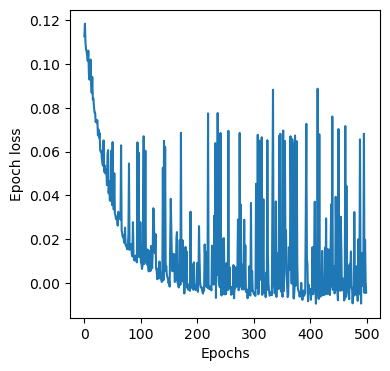

training_loss -0.004463891047012806
Average pos.mean:0.17222794890403748, Average pos_var: 0.0005431913305073977
(82,)

------------------Latent_dim:6	Exploration Step:3 ----------------------- 
82


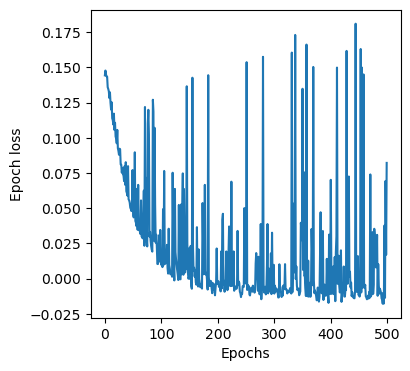

training_loss 0.08214367981891937
Average pos.mean:0.19302043318748474, Average pos_var: 0.0006402790313586593
(85,)

------------------Latent_dim:6	Exploration Step:4 ----------------------- 
85


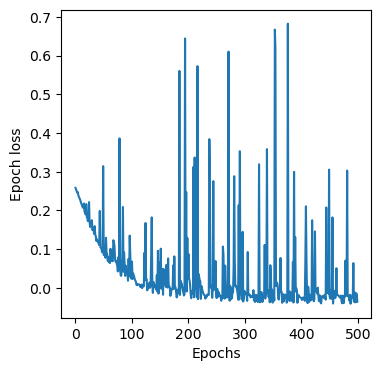

training_loss -0.035906667546668554
Average pos.mean:0.14471882581710815, Average pos_var: 0.0009022066369652748
(88,)

------------------Latent_dim:6	Exploration Step:5 ----------------------- 
88


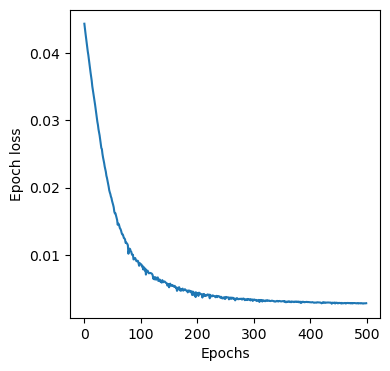

training_loss 0.0028130419797076167
Average pos.mean:0.16578161716461182, Average pos_var: 0.0004685180610977113
(91,)

------------------Latent_dim:6	Exploration Step:6 ----------------------- 
91


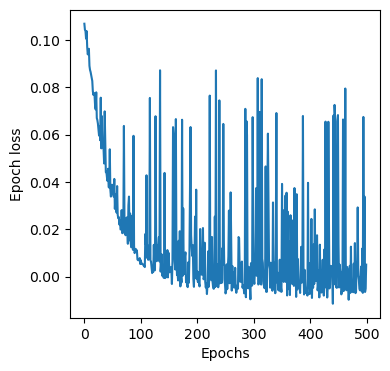

training_loss 0.005032824460515522
Average pos.mean:0.15884293615818024, Average pos_var: 0.0005713551654480398
(94,)

------------------Latent_dim:6	Exploration Step:7 ----------------------- 
94


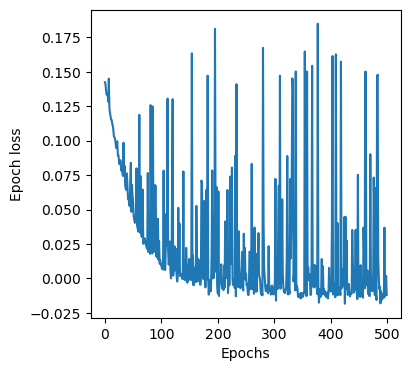

training_loss -0.012001915998432287
Average pos.mean:0.16376541554927826, Average pos_var: 0.0008565815514884889
(97,)

------------------Latent_dim:6	Exploration Step:8 ----------------------- 
97


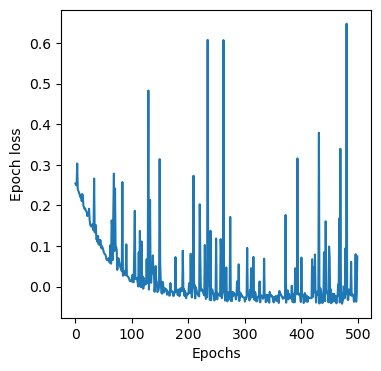

training_loss 0.07463938011397406
Average pos.mean:0.17832832038402557, Average pos_var: 0.0008105389424599707
(100,)

------------------Latent_dim:6	Exploration Step:9 ----------------------- 
100


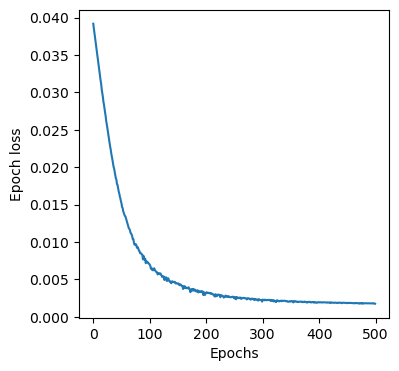

training_loss 0.0017433693612939891
Average pos.mean:0.14286431670188904, Average pos_var: 0.00045168696669861674
(103,)

------------------Latent_dim:6	Exploration Step:10 ----------------------- 
103


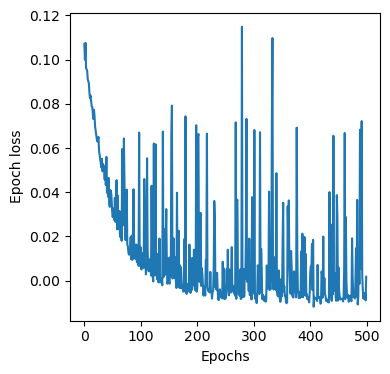

training_loss 0.0017487705188336418
Average pos.mean:0.12247984856367111, Average pos_var: 0.0005474130739457905
(106,)
Intitial_dataset_score: tensor(93.2249)


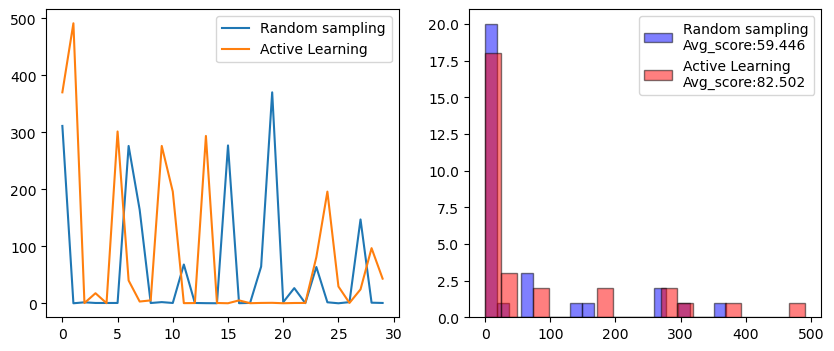


------------------Latent_dim:10	Exploration Step:1 ----------------------- 
76


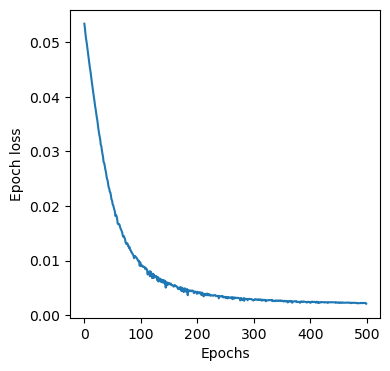

training_loss 0.002086984592905984
Average pos.mean:0.1507539302110672, Average pos_var: 0.000579099403694272
(79,)

------------------Latent_dim:10	Exploration Step:2 ----------------------- 
79


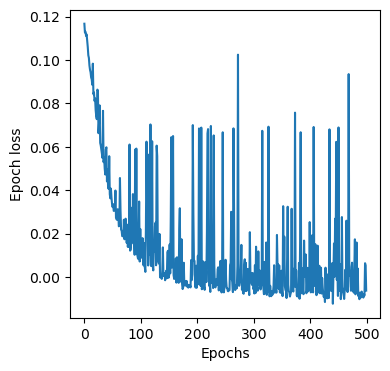

training_loss -0.0062891466081500865
Average pos.mean:0.16866116225719452, Average pos_var: 0.000600729021243751
(82,)

------------------Latent_dim:10	Exploration Step:3 ----------------------- 
82


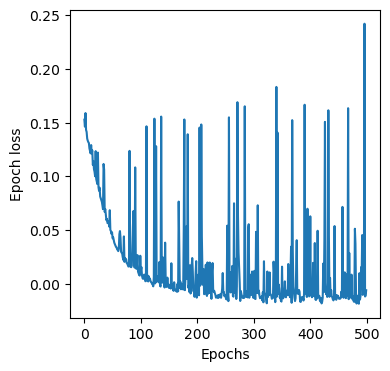

training_loss -0.005880745401435622
Average pos.mean:0.16858647763729095, Average pos_var: 0.0006647944101132452
(85,)

------------------Latent_dim:10	Exploration Step:4 ----------------------- 
85


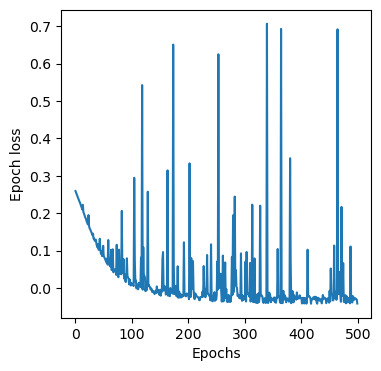

training_loss -0.04142722538178177
Average pos.mean:0.1115814596414566, Average pos_var: 0.0008463209378533065
(88,)

------------------Latent_dim:10	Exploration Step:5 ----------------------- 
88


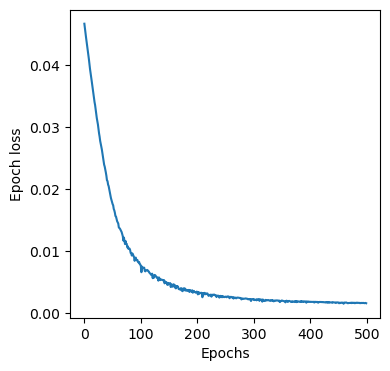

training_loss 0.0015902595085371173
Average pos.mean:0.1503886580467224, Average pos_var: 0.0006432363879866898
(91,)

------------------Latent_dim:10	Exploration Step:6 ----------------------- 
91


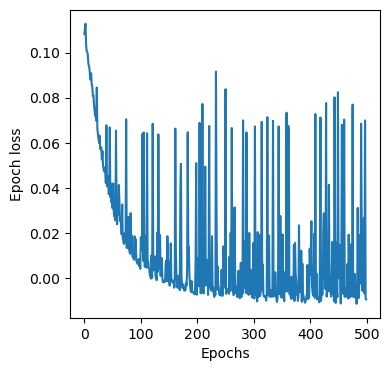

training_loss -0.009345280544611222
Average pos.mean:0.13886885344982147, Average pos_var: 0.0006220409995876253
(94,)

------------------Latent_dim:10	Exploration Step:7 ----------------------- 
94


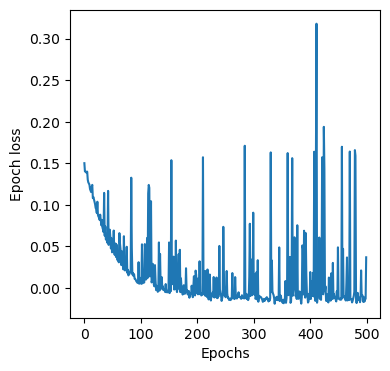

training_loss 0.03686882037947635
Average pos.mean:0.13136810064315796, Average pos_var: 0.0007148923468776047
(97,)

------------------Latent_dim:10	Exploration Step:8 ----------------------- 
97


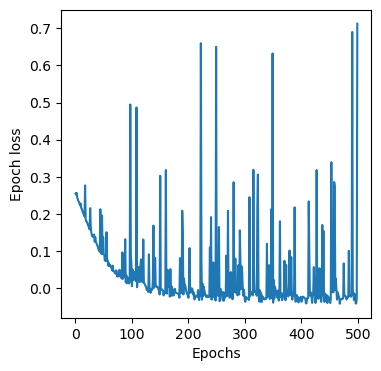

training_loss 0.712264808707112
Average pos.mean:0.13529379665851593, Average pos_var: 0.0009012542432174087
(100,)

------------------Latent_dim:10	Exploration Step:9 ----------------------- 
100


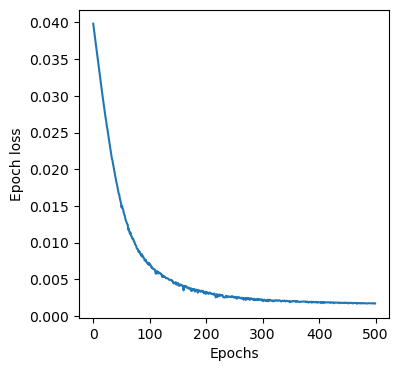

training_loss 0.0017342858875245626
Average pos.mean:0.14636094868183136, Average pos_var: 0.0005261038313619792
(103,)

------------------Latent_dim:10	Exploration Step:10 ----------------------- 
103


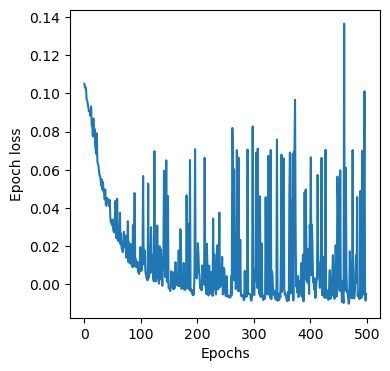

training_loss -0.0050107175723578794
Average pos.mean:0.16818417608737946, Average pos_var: 0.0007304862956516445
(106,)
Intitial_dataset_score: tensor(93.2249)


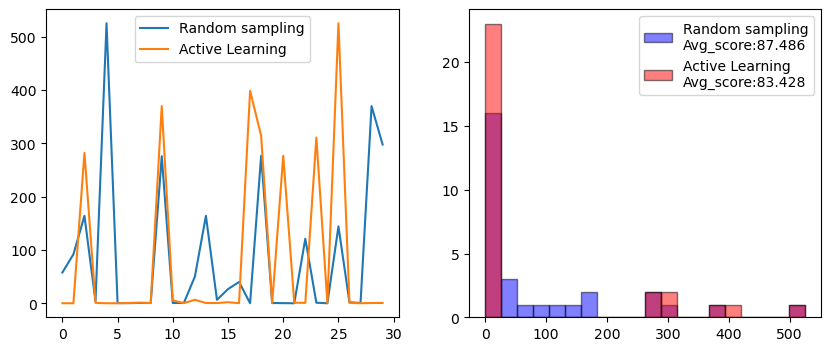


------------------Latent_dim:16	Exploration Step:1 ----------------------- 
76


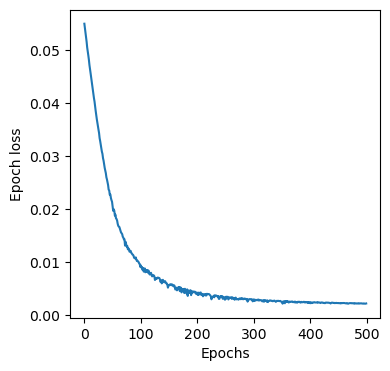

training_loss 0.002238413290817281
Average pos.mean:0.15729764103889465, Average pos_var: 0.0006850901409052312
(79,)

------------------Latent_dim:16	Exploration Step:2 ----------------------- 
79


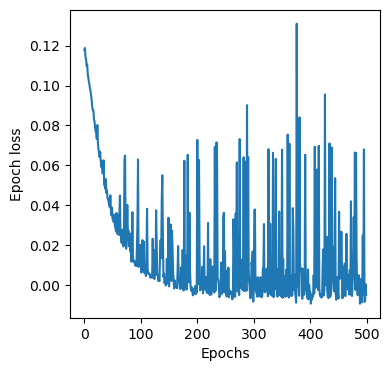

training_loss -0.004822423738636785
Average pos.mean:0.16364775598049164, Average pos_var: 0.0008508976316079497
(82,)

------------------Latent_dim:16	Exploration Step:3 ----------------------- 
82


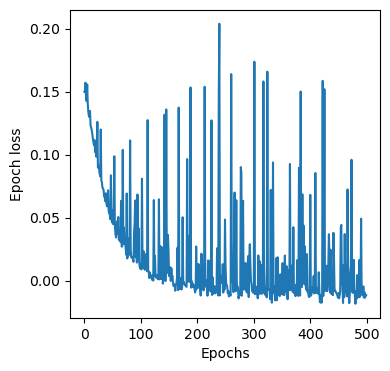

training_loss -0.011441997169002927
Average pos.mean:0.12516580522060394, Average pos_var: 0.0007659855764359236
(85,)

------------------Latent_dim:16	Exploration Step:4 ----------------------- 
85


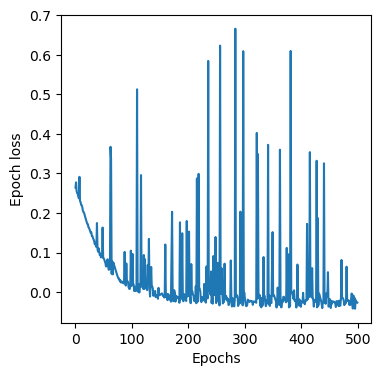

training_loss -0.026522782267710286
Average pos.mean:0.12409404665231705, Average pos_var: 0.0011754757724702358
(88,)

------------------Latent_dim:16	Exploration Step:5 ----------------------- 
88


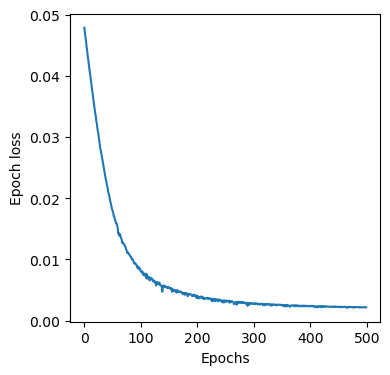

training_loss 0.0021651380715260416
Average pos.mean:0.15086866915225983, Average pos_var: 0.0007121554226614535
(91,)

------------------Latent_dim:16	Exploration Step:6 ----------------------- 
91


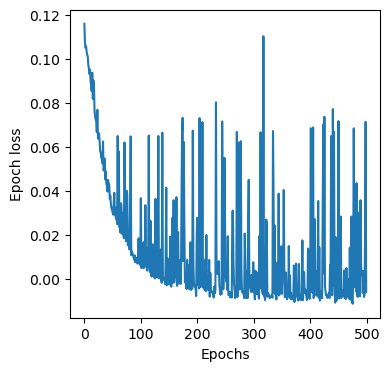

training_loss -0.006144737056505721
Average pos.mean:0.15284596383571625, Average pos_var: 0.0006697062635794282
(94,)

------------------Latent_dim:16	Exploration Step:7 ----------------------- 
94


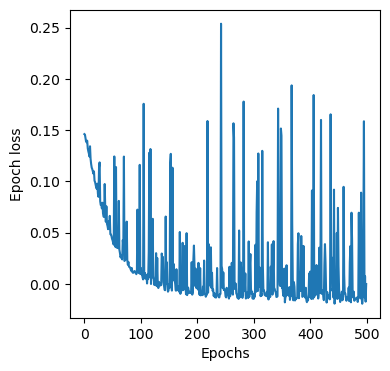

training_loss -0.00025404701229937504
Average pos.mean:0.16713282465934753, Average pos_var: 0.00085136090638116
(97,)

------------------Latent_dim:16	Exploration Step:8 ----------------------- 
97


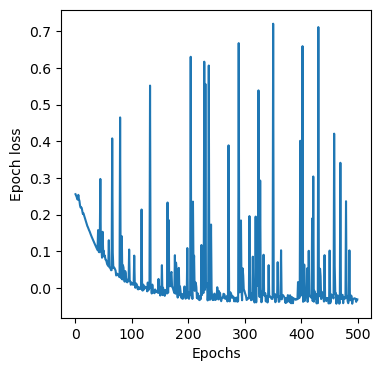

training_loss -0.030754121031891807
Average pos.mean:0.11067168414592743, Average pos_var: 0.0009692213498055935
(100,)

------------------Latent_dim:16	Exploration Step:9 ----------------------- 
100


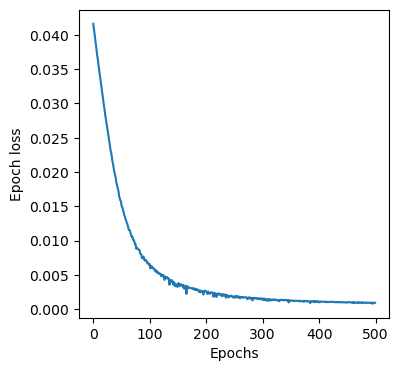

training_loss 0.0009579730633598303
Average pos.mean:0.13953638076782227, Average pos_var: 0.0006771771586500108
(103,)

------------------Latent_dim:16	Exploration Step:10 ----------------------- 
103


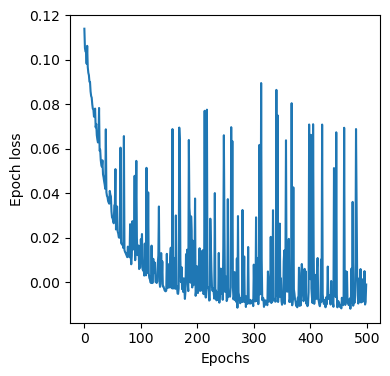

training_loss -0.0010686447938245223
Average pos.mean:0.1442110240459442, Average pos_var: 0.0007049486739560962
(106,)
Intitial_dataset_score: tensor(93.2249)


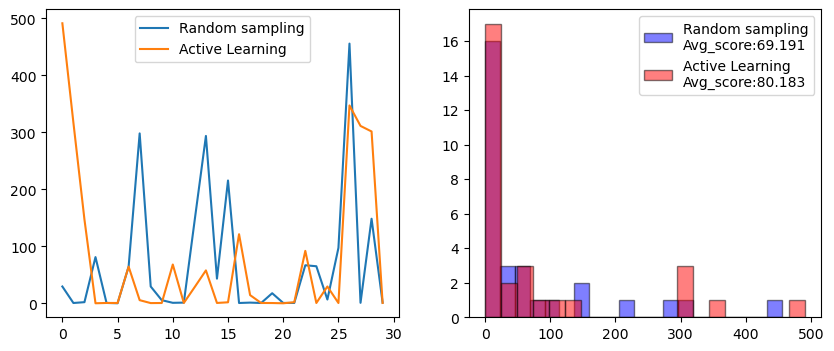

In [9]:

for latent_dim in latent_dims:
    
    # Initialize trainset

    train_X, test_X, train_params, test_params, train_y, test_y, train_indices, test_indices =train_test_split(X, params, y, 
                                                                                                           indices, 
                                                                                                           test_size=initial_test_fraction, 
                                                                                                           random_state = random_state)
    
    initial_trainsize = train_indices.shape[0]

    train_dataset = TrainDataset(train_X, train_params, train_y, transform = None)
    
    
    al_scores = []
    ran_scores = []

    for i in range(exploration_steps):

        print(f"\n------------------Latent_dim:{latent_dim}\tExploration Step:{i+1} ----------------------- ")

        custom_nn = LSTMCNN_FeatureExtractor(output_dim = latent_dim)

        device  = "cuda" if torch.cuda.is_available() else 'cpu'

        
        train_dataset = TrainDataset(train_X, train_params, train_y, transform = None)
        print(len(train_dataset))

        # Contruct the GP surrogate function
        model, training_loss = train_custom_nn_DKL(train_dataset, custom_nn, num_epochs = n_epochs, n_batches = n_batches, 
                                               lr_custom_nn = lr_custom_nn, lr_gp = lr_gp, device= device, plot_loss = True)
        
      

        print("training_loss", training_loss[-1])

        # Calculate the predicted posterior mean and variance
        y_means, y_vars = DKL_posterior(model, X)

        print(f"Average pos.mean:{y_means.mean()}, Average pos_var: {y_vars.mean()}")

        # Calculate the acquisition function
        #acq_ind, acq_val_max, Acq_vals = acq_fn_EI(y_means, y_vars, train_y, index_exclude= train_indices)

        
        acq_ind, acq_val_max, Acq_vals = acq_fn_UCB(y_means, y_vars, beta = beta, index_exclude= train_indices, 
                                                    sample_next_points = sample_next_points)

        # best estimates
        #X_best_train, X_best_pred = best_mean_estimate(train_X, train_y, X, y_means)


        for ind in acq_ind:

            # Acquire next point

            next_score = score[ind].detach().numpy().squeeze()
            al_scores.append(next_score)

            #randomly acquire
            ran_ind = random.choice(test_indices)
            ran_score = score[ran_ind].detach().numpy().squeeze()
            ran_scores.append(ran_score)


                    #Update training data
            train_X, train_y, train_params, train_indices = append_to_train(X, y, params, train_X, train_y, train_params, 
                                                                            train_indices, ind)
            test_indices = np.delete(test_indices, np.where(test_indices == ind))


        print(train_indices.shape)

    al_scores = np.asarray(al_scores)
    ran_scores = np.asarray(ran_scores)
    
    
    # Save trainindices
    
    np.savetxt(os.path.join(save_folder, f'train_indices_ldim{latent_dim}.txt'), train_indices.T)
    
    
    # Savefigure
    fig, ax = plt.subplots(1, 2, figsize = (10, 4))

    print("Intitial_dataset_score:", score[train_indices[0:initial_trainsize]].mean())

    ax[0].plot(ran_scores, label = 'Random sampling')
    ax[0].plot(al_scores, label = 'Active Learning')
    ax[0].legend()

    ax[1].hist(ran_scores, bins=20, alpha=0.5, label=f'Random sampling\nAvg_score:{ran_scores.mean():.3f}', color='blue', edgecolor='black')
    ax[1].hist(al_scores, bins=20, alpha=0.5, label=f'Active Learning\nAvg_score:{al_scores.mean():.3f}', color='red', edgecolor='black')
    ax[1].legend()

    plt.savefig(os.path.join(save_folder, f'scorehist_ldim{latent_dim}.jpg'), bbox_inches = 'tight')
    plt.show()
    
    
    